In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
# from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f'TensorFlow Version: {tf.__version__}')

TensorFlow Version: 2.1.0


# Data preprocessing

## Data download

In [2]:
train_dir = './nature_scene/seg_train/seg_train'
validation_dir = './nature_scene/seg_test/seg_test/'
test_dir = './nature_scene/seg_pred/seg_pred/'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (192, 192)
train_datagen = ImageDataGenerator(
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator()

In [4]:
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=IMG_SIZE)
val_dataset = validation_datagen.flow_from_directory(validation_dir,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=IMG_SIZE)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


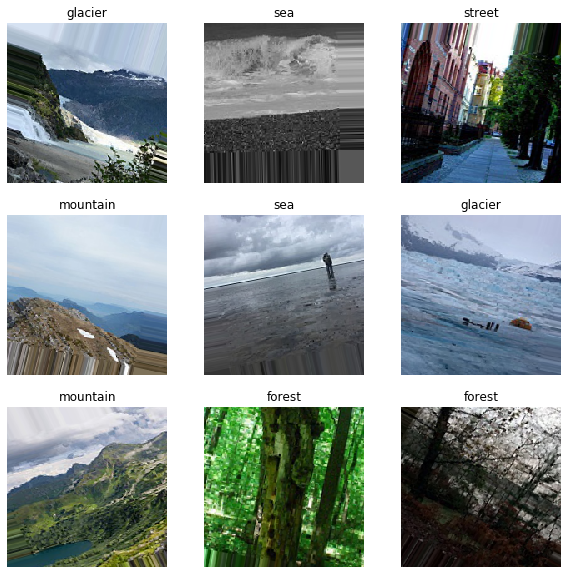

In [5]:
class_names = {v: k for k, v in train_dataset.class_indices.items()}

plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_dataset[0][0][i].astype('uint8'))
    plt.title(class_names[np.argmax(train_dataset[0][1][i])])
    plt.axis('off')

# Create the base model from the pretrained convnets

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(192, 192, 3)


In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Feature Extraction

## Freeze the convolutional base

In [8]:
base_model.trainable = False

## Important note about Batchnormlization layers
- 设置layer.trainable = False时，Batchnormalization会以推断模式运行，不会更改相应的均值方差
- 当你为了微调没有freeze带有batchnormalization层的模型时，调用该模型时应传入training=False使BN层以推断模式运行

## Build Model by keras function API

In [9]:
num_classes = len(class_names)
inputs = tf.keras.Input(shape=(192, 192, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686  

## Compile the model
- 标签有两个类别，损失函数使用二分交叉熵损失函数，model最后是线性输出，设置from_logit=True

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model 

In [12]:
# 查看模型初始精度
loss0, acc0 = model.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

  ...
    to  
  ['...']
94/94 [==============================] - 33s 352ms/step - loss: 2.4305 - accuracy: 0.1187
initial loss: 2.43
initial accuracy: 0.12


In [13]:
initial_epochs = 10 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 439 steps, validate for 94 steps
Epoch 1/10
439/439 [==============================] - 198s 452ms/step - loss: 1.2110 - accuracy: 0.5317 - val_loss: 0.6407 - val_accuracy: 0.7900
Epoch 2/10
439/439 [==============================] - 203s 463ms/step - loss: 0.6117 - accuracy: 0.7781 - val_loss: 0.4339 - val_accuracy: 0.8540
Epoch 3/10
439/439 [==============================] - 203s 462ms/step - loss: 0.5075 - accuracy: 0.8156 - val_loss: 0.3683 - val_accuracy: 0.8783
Epoch 4/10
439/439 [==============================] - 204s 465ms/step - loss: 0.4607 - accuracy: 0.8295 - val_loss: 0.3322 - val_accuracy: 0.8877
Epoch 5/10
439/439 [==============================] - 206s 470ms/step - loss: 0.4295 - accuracy: 0.8419 - val_loss: 0.3112 - val_accuracy: 0.8907
Epoch 6/10
439/439 [==============================] - 199s 454ms/step - loss: 0.4099 - accuracy: 0.8492 - val_loss: 0.2967 - val_accuracy: 0.8970
Epoch 7/10
439/439 [===========

## Learn crves
- Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

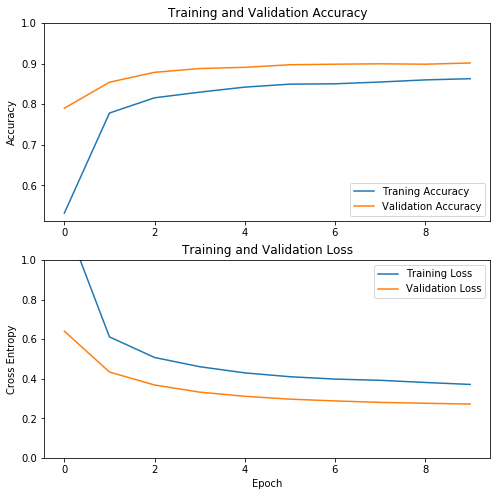

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Traning Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Fine Tune

## Un-freeze the top layers of the model

In [15]:
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 155


In [16]:
# fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686  

In [18]:
len(model.trainable_variables)

58

## Complie the model

In [19]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Continue training the model

In [20]:
fine_tune_epochs = 10 
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 439 steps, validate for 94 steps
Epoch 10/20
439/439 [==============================] - 306s 696ms/step - loss: 0.3473 - accuracy: 0.8722 - val_loss: 0.2340 - val_accuracy: 0.9163
Epoch 11/20
439/439 [==============================] - 308s 703ms/step - loss: 0.3072 - accuracy: 0.8873 - val_loss: 0.2271 - val_accuracy: 0.9130
Epoch 12/20
439/439 [==============================] - 303s 689ms/step - loss: 0.2822 - accuracy: 0.8968 - val_loss: 0.2195 - val_accuracy: 0.9200
Epoch 13/20
439/439 [==============================] - 300s 683ms/step - loss: 0.2653 - accuracy: 0.9042 - val_loss: 0.2074 - val_accuracy: 0.9227
Epoch 14/20
439/439 [==============================] - 295s 673ms/step - loss: 0.2503 - accuracy: 0.9091 - val_loss: 0.2178 - val_accuracy: 0.9163
Epoch 15/20
439/439 [==============================] - 300s 682ms/step - loss: 0.2397 - accuracy: 0.9143 - val_loss: 0.2087 - val_accuracy: 0.9250
Epoch 16/20
439/439 [====

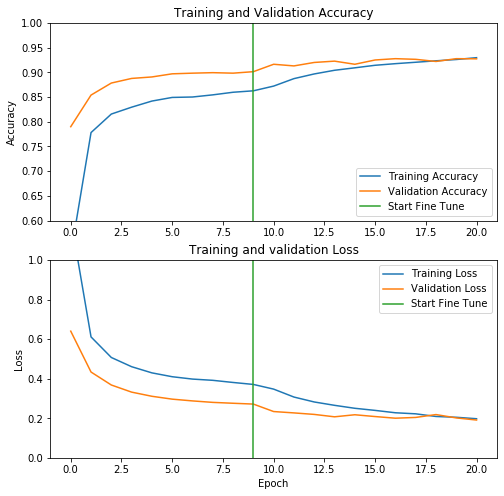

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(),
         label='Start Fine Tune')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1,], 
         plt.ylim(),
         label='Start Fine Tune')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')
plt.show()

## Evaluation and Prediction

In [23]:
loss, acc = model.evaluate(val_dataset)
print(f'Test Accuracy: {acc}')

  ...
    to  
  ['...']
94/94 [==============================] - 30s 321ms/step - loss: 0.1910 - accuracy: 0.9273
Test Accuracy: 0.9273333549499512


In [36]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print(f'Predictions: \n {predictions.numpy()}')
print(f'Labels: \n {label_batch}')

Predictions: 
 [0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0]
Labels: 
 [0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0]


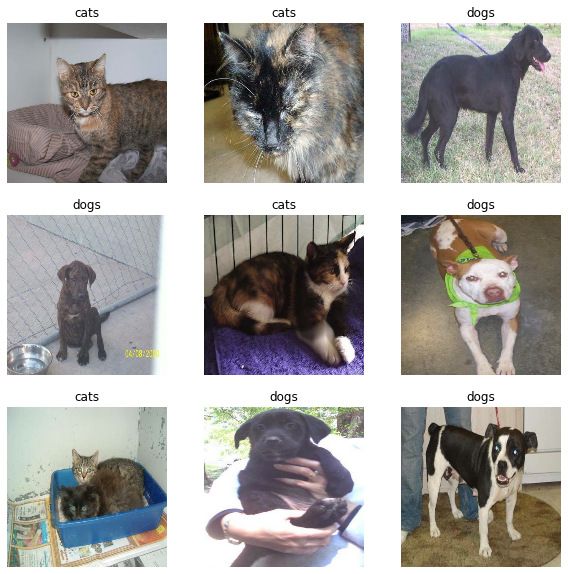

In [37]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis('off')